# 2주차 주제분석 패키지 (Catboost, Ridge Regression, Light GBM)

In [1]:
# 라이브러리 호출
import pandas as pd
import numpy as np

### 데이터 분할

#### 데이터 불러오기

In [2]:
train = pd.read_csv("C://Users//yjs49//Desktop//lgbm//train.csv")
test = pd.read_csv("C://Users//yjs49//Desktop//lgbm//test.csv")

#### 단위 수정

In [3]:
### 결국 price를 예측하는 것!
train_x = train.drop(['price'], axis=1)
train_y = train['price']

#### validation set 분할

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

#### 이렇게 split할 경우 발생할 수 있는 문제점
: 우리는 최종적으로 아파트 실거래가격(price)을 예측하려고 함. 즉, 과거의 정보를 활용하여 미래의 정보를 얻어내야 한다.
validation set을 만드는 목적은 bias가 작은 모델을 만들기 위해 train set을 이용하여 만든 모델을 평가, 즉 test error를 추정하기 위한 것.
그러나 위의 방식으로 train과 valid set을 나누면, train set에 과거 뿐만 아니라 예측하려는 시점의 정보도 포함되어 있는 것과 같아 test error rate를 올바르게 추정할 수 없음!
(시계열데이터이기 때문임!!!)

#### validation set 분할 두번쨰!

In [5]:
### transaction_year == 4인 행을 validation set으로 지정!

train2 = train[train['transaction_year'] <4]
val2 = train[train['transaction_year'] == 4]

x_train = train2.drop(['price'], axis = 1)
y_train = train2['price']

x_val = val2.drop(['price'], axis = 1)
y_val = val2['price']

#### Catboost encoding 전! 

In [6]:
!pip install category_encoders

CatBoostEncoder 설명
: Encoding은 범주형 변수를 수치형 변수로 바꾸어주면서 ML을 할 수 있도록 하는 것!
-> CatBoost는 target based 범주형 인코더, supervised encoder
: 모든 훈련 데이터를 대상으로 잔차계산을 하는 기존의 부스팅 모델과 달리, Catboost는 일부만 가지고 잔차계산을 한 뒤, 이걸로 모델을 만들고 데이터의 잔차는 이 모델로 예측한 값을 사용한다. (점차적으로 순서에 따라 모델을 만들고 예측을 한다!, random permutation을 통해 트리를 다각적으로 생성한다.)
: 현재 타켓 값을 사용하지 않고, 이전 데이터들의 타켓 값만을 사용해서 data leakage를 방지한다. 그래서 범주형 변수를 수로 인코딩할 때 오버피팅도 방지하고, 수치값의 다양성도 만들어줄 수 있다!
: 변수가 범주형 변수일 떄 효과적인 학습 속도도 보인다. (파라미터 튜닝은 그렇게 중요하진 않음)

애초에 boosting 모델은 잔차를 줄여나가는데에 그 목표가 있기 떄문에 high variance한 모델이다(오버피팅도 많이 발생한다.)
xgboost, catboost(level-wise : BFS의 형태) / lgbm(leaf-wise : DFS의 형태)

In [7]:
from category_encoders.cat_boost import CatBoostEncoder

cbe_encoder = CatBoostEncoder()
cbe_encoder.fit(x_train, y_train)
cbe_train = cbe_encoder.fit_transform(x_train, y_train)
cbe_val = cbe_encoder.transform(x_val)
# train에서 분할된 train을 인코딩을 위한 학습으로 사용해서, 이를 valid에 적용한 것!

cbe_val.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
2451,89176.597368,86280.203194,107.91,14,4,9,-1.000000e+00,-1.836970e-16
2452,89176.597368,86280.203194,151.81,10,4,9,-1.000000e+00,-1.836970e-16
2453,89176.597368,86280.203194,94.51,2,4,9,-2.449294e-16,1.000000e+00
2454,89176.597368,86280.203194,94.28,12,4,9,-2.449294e-16,1.000000e+00
2455,103789.156533,107170.755379,145.96,13,4,13,-1.000000e+00,-1.836970e-16


In [8]:
x_train

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,사직동,광화문풍림스페이스본(9-0),95.88,6,0,5,-1.000000e+00,-1.836970e-16
1,사직동,광화문풍림스페이스본(9-0),108.55,11,0,5,-2.449294e-16,1.000000e+00
2,사직동,광화문풍림스페이스본(9-0),94.51,1,0,5,-2.449294e-16,1.000000e+00
3,수송동,로얄팰리스스위트,42.87,8,0,8,-1.000000e+00,-1.836970e-16
4,수송동,로얄팰리스스위트,39.67,15,0,8,1.000000e+00,3.061617e-16
...,...,...,...,...,...,...,...,...
416312,강일동,강일리버파크4단지,84.74,9,3,7,5.879543e-15,-1.000000e+00
416313,강일동,강일리버파크2단지,84.53,7,3,7,5.879543e-15,-1.000000e+00
416314,강일동,강일리버파크5단지,84.83,6,3,7,5.879543e-15,-1.000000e+00
416315,강일동,강일리버파크4단지,84.53,13,3,7,5.879543e-15,-1.000000e+00


In [9]:
cbe_train ###수치형 값들이 범주형으로 변환되었고, 값들이 다 차이가 있다. (dong, apt가 변형됨!)

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,46056.618349,46056.618349,95.88,6,0,5,-1.000000e+00,-1.836970e-16
1,58028.309174,58028.309174,108.55,11,0,5,-2.449294e-16,1.000000e+00
2,72185.539450,72185.539450,94.51,1,0,5,-2.449294e-16,1.000000e+00
3,46056.618349,46056.618349,42.87,8,0,8,-1.000000e+00,-1.836970e-16
4,38278.309174,38278.309174,39.67,15,0,8,1.000000e+00,3.061617e-16
...,...,...,...,...,...,...,...,...
416312,41881.068296,42999.460791,84.74,9,3,7,5.879543e-15,-1.000000e+00
416313,41884.564849,41768.869699,84.53,7,3,7,5.879543e-15,-1.000000e+00
416314,41886.606774,38481.447103,84.83,6,3,7,5.879543e-15,-1.000000e+00
416315,41892.019883,43024.466183,84.53,13,3,7,5.879543e-15,-1.000000e+00


### 릿지 회귀 (Ridge Regression)
- 정규화의 개념(Regularization)
: 모든 변수로 모델을 적합하되, 회귀 계수가 가질 수 있는 값에 제약조건을 부여함으로써 계수들을 작게 만들거나 0으로 만드는 방법. 다중공선성을 일으키는 문제 중 하나가 OLS 추정량의 분산을 크게 증가시킨다는 것이었는데, 분산이 크게 증가하게 된다면 추정량의 변동폭이 매우 크게되어 예측이 불안정해진다.
-> 추정량의 크기를 제한함으로써 변동폭을 줄이고, 이를 통해 분산을 줄인다는 아이디어! (OLS 추정량의 불편성을 포기하고 분산을 줄이는 방법)

- 릿지 회귀(Ridge) 
: 제약조건이 L2norm의 형태(원) -> 변수 선택 불가능, closed form solution을 미분을 통해 구할 수 있음
: 상관관계 높은 상황에서 좋은 예측 성능 (상관성이 있는 변수들에 대해서 적절한 가중치 배분)

- 라소 회귀(Lasso)
: 제약조건이 L1norm의 형태(마름모) -> 변수 선택 가능, closed form solutuon이 존재하지 않고 numerical optimization을 써서 해 구해야 함
: 상관관계가 높다면, 하나는 큰 값, 하나는 0이 나와서 변수선택의 역할을 수행할 수는 있으나 Ridge에 비해 상대적으로 예측 성능은 떨어짐

#### 상관계수 플랏

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

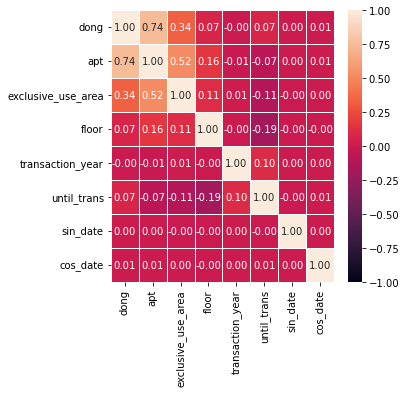

In [11]:
fid, ax = plt.subplots(figsize = (5,5))
sns.heatmap(data = cbe_train.corr(), annot=True, fmt = '.2f', linewidths=.5,
vmin = -1,vmax = 1)
plt.show()

Ridge회귀가 잘 작동하지 않는다!
- 이유 : Ridge 회귀가 필요한 상황은 다중공선성 문제가 있을 때!
-> 상관계수 플랏을 확인해 보았을 때, 변수들간 상관계수가 대부분 낮음을 알 수 있음. dong이랑 dpt는 상관관계가 높게 나타나기는 하는데, 유의한 해석이 나올 것 같지는 않음.

#### 해석과 무관하게 일단 Ridge Regression Tuning하기!

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

In [13]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
mse = [0, 0, 0, 0, 0]

for i in range(5):
    alpha = alphas[i]
    ridge = Ridge(alpha)
    ridge.fit(cbe_train, y_train)
    pred = ridge.predict(cbe_val)
    mse[i] = sqrt(mean_squared_error(pred, y_val))

In [14]:
mse

[14777.88141950205,
 14777.88141959242,
 14777.881420496149,
 14777.881429533429,
 14777.881519906232]

#### 튜닝결과 시각화

In [15]:
mse.index(min(mse))

0

([<matplotlib.axis.XTick at 0x1c055779430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

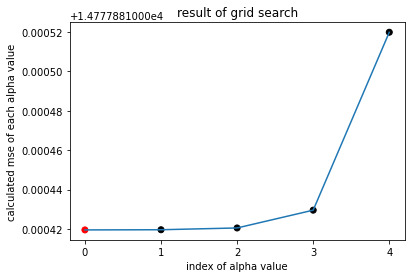

In [16]:
plt.scatter(range(0,5), mse, c=['red', 'black', 'black', 'black', 'black'])
plt.plot(range(0,5), mse)
plt.title("result of grid search")
plt.xlabel("index of alpha value")
plt.ylabel("calculated mse of each alpha value")
plt.xticks(range(0,5))

alpha가 가장 작은 값일 떄 mse가 가장 낮습니다.
-> 다중공선성이 존재하는 경우 베타의 분산이 매우 커지는데, 이때 bias-variane trade-off를 이용하여 bias는 조금 늘리는 대신 variance를 줄여주는 방법 중 하나가 ridge regression이다.
alpha는 penalty term으로서, 베타를 추정할 때 특정 범위 안에 존재할 수 있도록 조절해주는 역할을 수행하는데, alpha가 0에 가까울수록 LSE를 추정하는 것과 비슷해진다는 것을 의미한다.
(x값의 단위가 높으면 제한을 걸어서 그 값을 낮추기 위해 매우 작은 alpha값이 필요하게 되고, alpha 값이 작아짐에 따라 성능의 효율이 감소하게 된다!)

-> 위의 plot에서 확인할 수 있었듯이, 해당 데이터는 독립변수 간의 상관관계가 거의 존재하지 않았다. 따라서 이러한 Ridge의 방법이 필요하지 않은 상황이라고 해석할 수 있기에 alpha 값이 가장 작았을 때 mse값이 가장 작게 나온 것 같다고 해석할 수 있다.

-> ex) alpha가 극단적으로 0으로 가게 된다면, 이는 일반 선형회귀와 다를게 없음!

#### 단순 성형 모형 이용
: 굳이 Ridge, Lasso 쓸 필요가 없었기 때문! linear regression은 다른 tuning parameter를 필요로 하지 않음

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
linear_reg = LinearRegression()
linear_reg.fit(cbe_train, y_train)
pred = linear_reg.predict(cbe_val)

linear_reg_mse = sqrt(mean_squared_error(pred, y_val))

In [19]:
linear_reg_mse < min(mse)

True

위를 통해 단순 Linear Regresssion의 결과가 Ridge Regression의 최소 mse보다 작게 추정됨을 확인할 수 있다. 따라서 굳이 bias를 희생하면서까지 Ridge를 쓰는 것 보다, 위 데이터에서는 Linear Regression이 더 적절하다고 판단할 수 있다!

### Light GBM

In [20]:
!pip install lightgbm

#### Light GBM의 이해

- 부스팅 모델: 부스팅 알고리즘은 틀린 부분에 가중치를 더하면서 진행하는 알고리즘이고, 그 중 gradient boosting은 그 가중치를 경사하강법으로 진행하는 것이다.
- Light GBM은 대용량 데이터 처리가 가능하고, 다른 모델보다 더 적은 자원을 사용하여 빠른 속도를 자랑한다는 장점이 있다. (그러나 너무 적은 데이터를 이용하면 과적합의 위험이 있다.)
- Leaf-wise 트리 분할을 사용하여 트리의 균형을 맞추기 보다는 leaf node를 지속적으로 분할하면서 진행하기 떄문에 Level-wise 보다 연산량이 적다는 장점이 있다. (비대칭적인 규칙 트리)
- learning rate를 줄이면서 n_estimator를 크게 하는 것이 부스팅 모델에서는 기본적인 튜닝 방법이다.
-> 최대 손실값을 가지는 leaf node를 지속적으로 분할해 생성된 규칙트리는 학습을 반복할수록 결국 균형 트리 분할 방식보다 예측 오류 손실을 최소화할 수 있다고 생각한 것!

#### 파라미터 설명
- num_leaves : 늘리면 정확도는 높아지지만, 트리가 점점 깊어지고 과적합의 가능성이 있음
- min_child_sample : 크게 설정하여 트리가 깊어지는 것을 방지할 수 있음
- max_depth : 깊이 제한을 통해 과적합을 개선할 수 있음

#### Light GBM 튜닝
: max_depth, learning_rate, lambda, min_child_samples 등 다양
-> 부스팅에서는 일단 learning rate와 iteration의 trade-off를 적절하게 고려하여서 학습속도를 맞춰준 다음, 세부적인 튜닝을 진행한다!
보통 enumerate를 통해 파라미터를 묶어주고 튜닝을 진행한다!

In [44]:
learning_rate = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99]

In [45]:
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

In [46]:
mse = [0, 0, 0, 0, 0, 0, 0]
for i in range(7):
    lr = learning_rate[i]
    lgbm = LGBMRegressor(learning_rate = lr)
    lgbm.fit(cbe_train, y_train)
    pred = lgbm.predict(cbe_val)
    mse[i] = sqrt(mean_squared_error(pred, y_val))

In [47]:
mse

[20425.56868365825,
 12022.076838668658,
 11590.66141311688,
 11203.645981790534,
 11529.176861780024,
 13135.209268880475,
 12646.056552072083]

In [48]:
mse.index(min(mse))

3

####  튜닝 결과 시각화

Text(2, 12000, 'smallest mse with alpha = 11203 ')

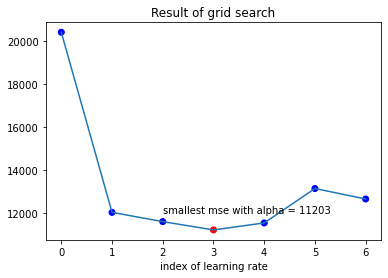

In [38]:
plt.scatter(range(0,7), mse , c=['blue','blue','blue','red','blue','blue','blue']) #시각화 꼭 해라~
plt.plot(range(0,7), mse)
plt.title("Result of grid search")
plt.xlabel("index of learning rate")
plt.xticks(range(0,7))
plt.text(2,12000, "smallest mse with alpha = 11203 ")

#### 튜닝 추가 설명
- Grid Search
: 사전에 지정한 여러개의 잠재적 parameter 후보군들의 조합 중에서 가장 최적의 조합을 찾는 과정이다.즉, 모든 경우의 수의 조합을 이용하여 가장 우수한 성능을 보이는 parameter 조합을 찾는 것으로, 하나하나 해보기 때문에 parameter 수가 늘어날수록 시간이 아주 오래 걸린다는 단점도 있다.

- Random Search
: 파라미터 값을 랜덤하게 선택한 후, 그 중 우수한 성능을 보인 파라미터를 이용하여 모델을 생성하는 방식이다. 이는 Grid Search에 비해 불필요한 탐색 횟수를 줄여준다는 점에서 특징을 지닌다. 랜덤하게 숫자를 넣은 뒤, 정해진 간격 사이에 위치한 값들에 대해서도 확률적으로 탐색이 가능하므로, 최적의 hyper_paramter를 더 빨리 찾을 수 있음

- Bayesian Optimization
: 기존의 결과들을 이용하여 parameter를 설정하는 방법이다.
-> surrogate model : 지금까지 추론한 결과들을 바탕으로 주로 Gaussian Process를 이용하여 f(x)의 대략적인 값을 추정하는 방식이다.

-> acquision model : surrogate model의 확률분포를 이용해서 지금까지 나온 값들보다 더 큰 값이 나올 가능성이 제일 높은 점을 알려주는 함수이다. 가장 큰 점을 찾기 위해 exploration(불확실성이 가장 높은 곳에서 지금까지 나온 값들보다 더 좋은 값이 있을 것이다) 전략과 expectation(지금까지 나온 것들 중에서 높은 값들 근처에서 더 좋은 것이 있을 것이다) 전략을 사용한다. => 이 둘이 적절한 균형을 이루도록 acquisition function을 만들고 이를 expected improvement 함수라고 한다.

- 추가적으로 연구 중인 Neural Process 기반 Optimization 방법...

### test set

#### test set 불러오기

In [39]:
x_test = test.drop(['price'], axis = 1)
y_test = test['price']

#### 캣부스트 인코딩

In [40]:
cbe_encoder = CatBoostEncoder()
cbe_encoder.fit(x_train, y_train)
train_cbe = cbe_encoder.fit_transform(x_train, y_train)
test_cbe  = cbe_encoder.transform(x_test)

In [41]:
test_cbe.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,89176.597368,86280.203194,70.80,1,5,10,-1.000000e+00,-1.836970e-16
1,89176.597368,86280.203194,94.51,8,5,10,-2.449294e-16,1.000000e+00
2,89176.597368,86280.203194,160.85,11,5,10,-2.449294e-16,1.000000e+00
3,89176.597368,86280.203194,94.51,6,5,10,1.000000e+00,3.061617e-16
4,89176.597368,86280.203194,136.40,3,5,10,1.000000e+00,3.061617e-16


#### 최적의 파라미터 적합

In [52]:
# Linear Regression
lr_reg = LinearRegression()
lr_reg.fit(train_cbe, y_train)
pred = lr_reg.predict(test_cbe)
reg_mse = sqrt(mean_squared_error(pred, y_test))

print(reg_mse)

19866.892948208435


In [49]:
# Light GBM
best_learning_rate = learning_rate[3]
lgbm = LGBMRegressor(learning_rate = best_learning_rate)
lgbm.fit(train_cbe, y_train)
pred = lgbm.predict(test_cbe)
lgbm_mse = sqrt(mean_squared_error(pred, y_test))

print(lgbm_mse)

17705.780985779136


In [53]:
lgbm.fit(train_cbe, y_train)

LGBMRegressor(learning_rate=0.3)

In [ ]:
#### test set에 대해 평가

In [50]:
reg_mse < lgbm_mse

False

In [54]:
print("Linear Regression : %f, Light GBM : %f" % (reg_mse, lgbm_mse))

Linear Regression : 19866.892948, Light GBM : 17705.780986


mse를 기준으로 비교하였을때, Light GBM이 더 우수한 성능을 보인다.
다른 파라미터도 조정해준다면 더 우수할 수 있을 것이다!